## Convolutional Neural Network in Keras for  Digit Classification

We want to classify hand written digits such as these:


The data set is the Kaggle version of MNIST.

In [0]:
import numpy as np
import pandas as pd

In [2]:
## IF YOU USE GOOGLE  COLAB
from google.colab import files
uploaded = files.upload()
import io
df_dataset = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

Saving dataset.csv to dataset (2).csv


In [3]:
df_dataset.shape

(42000, 785)

In [0]:
## IN CASE YOU USE YOUR OWN MACHINE
#df_dataset = pd.read_csv("./data/dataset.csv") 
#print("Dataset shape = " +str(df_dataset.shape))

In [4]:
df_dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The dataset is a dataframe, the first column consists of the label (a numer from 0 to 9), the other columns are the value of the pixels (from 0 to 255).

In [5]:
X=df_dataset.iloc[:,1:].values 
X.shape

(42000, 784)

In [6]:
Y=df_dataset.iloc[:,0].values 
Y.shape

(42000,)

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


## Preprocess data

$X$ must be reshaped as images of 28x28 pixels.

In [8]:
X = X.reshape(X.shape[0], 28, 28,1) 
X.shape

(42000, 28, 28, 1)

We write Y as one-hot vectors.

In [9]:
Y = keras.utils.to_categorical(Y, 10) 
print(Y.shape)

(42000, 10)


Now we split the data set into train and test sets.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state=42) 

In [11]:
print(X_train.shape)

(35700, 28, 28, 1)


We use Kares data augmentation to have a larger training set. We also normalize the trainig a test sets.

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255) 

## MODEL

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

In [0]:
initial_learningrate=1e-3 
batch_size = 64
epochs = 20
input_shape = (28, 28, 1)

We define a function that reduces the learning rate with the epochs.

In [0]:
def lr_decay(epoch):#lrv
    return initial_learningrate * 0.9 ** epoch

In [0]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=initial_learningrate),
              metrics=['accuracy'])

## Training

In [19]:
history = model.fit_generator(
      train_datagen.flow(X_train,Y_train, batch_size=batch_size),
      steps_per_epoch=100,
      epochs=epochs,
      callbacks=[LearningRateScheduler(lr_decay) 
               ],
      validation_data=test_datagen.flow(X_test,Y_test),
      validation_steps=50,  
      verbose=2)

Epoch 1/20
100/100 - 5s - loss: 0.7074 - acc: 0.7664 - val_loss: 1.9192 - val_acc: 0.3187
Epoch 2/20
100/100 - 2s - loss: 0.2361 - acc: 0.9306 - val_loss: 0.3821 - val_acc: 0.8431
Epoch 3/20
100/100 - 2s - loss: 0.1641 - acc: 0.9459 - val_loss: 0.3349 - val_acc: 0.9069
Epoch 4/20
100/100 - 2s - loss: 0.1365 - acc: 0.9565 - val_loss: 0.1048 - val_acc: 0.9712
Epoch 5/20
100/100 - 2s - loss: 0.1223 - acc: 0.9628 - val_loss: 0.1083 - val_acc: 0.9700
Epoch 6/20
100/100 - 2s - loss: 0.1020 - acc: 0.9700 - val_loss: 0.0601 - val_acc: 0.9800
Epoch 7/20
100/100 - 2s - loss: 0.0827 - acc: 0.9747 - val_loss: 0.0857 - val_acc: 0.9762
Epoch 8/20
100/100 - 2s - loss: 0.0834 - acc: 0.9747 - val_loss: 0.0656 - val_acc: 0.9844
Epoch 9/20
100/100 - 2s - loss: 0.0713 - acc: 0.9783 - val_loss: 0.0472 - val_acc: 0.9862
Epoch 10/20
100/100 - 2s - loss: 0.0663 - acc: 0.9787 - val_loss: 0.0337 - val_acc: 0.9887
Epoch 11/20
100/100 - 2s - loss: 0.0687 - acc: 0.9800 - val_loss: 0.0405 - val_acc: 0.9850
Epoch 12

The model trains really fast with a GPU, however it takes hours on a regular CPU.

## Plot

Let's plot the results

In [0]:
import matplotlib.pyplot as plt 


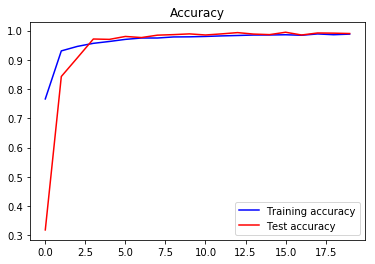

In [21]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


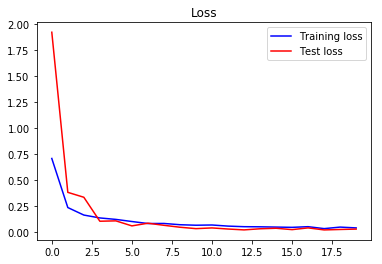

In [22]:
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Loss')
plt.legend()
plt.show()

We see that with only 20 epochs the model achieves a good accuracy. 